In [1]:
!mkdir -p gan_data/motorbike
!mkdir -p gan_data/images
!mkdir -p gan_data/weights
!gdown --id 1xBCbjopxZCvzzTMuRKKaTpF-i2jLz7xa -O gan_data/motorbike/full_numpy_bitmap_motorbike.npy

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1xBCbjopxZCvzzTMuRKKaTpF-i2jLz7xa
To: /content/gan_data/motorbike/full_numpy_bitmap_motorbike.npy
100% 133M/133M [00:03<00:00, 36.2MB/s]


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, ReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Input, UpSampling2D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
import os
from os import walk
import matplotlib.pyplot as plt
import matplotlib.image as mp_image

In [3]:
SAVE_FOLDER = 'gan_data'

def load_quickdraw(folder):

    mypath = os.path.join(SAVE_FOLDER, folder)
    txt_name_list = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        for f in filenames:
            if f != '.DS_Store':
                txt_name_list.append(f)
                break

    slice_train = int(80000/len(txt_name_list))  ###Setting value to be 80000 for the final dataset
    i = 0
    seed = np.random.randint(1, 10e6)

    for txt_name in txt_name_list:
        txt_path = os.path.join(mypath,txt_name)
        x = np.load(txt_path)
        x = (x.astype('float32') - 127.5) / 127.5
        # x = x.astype('float32') / 255.0

        x = x.reshape(x.shape[0], 28, 28, 1)

        y = [i] * len(x)
        np.random.seed(seed)
        np.random.shuffle(x)
        np.random.seed(seed)
        np.random.shuffle(y)
        x = x[:slice_train]
        y = y[:slice_train]
        if i != 0:
            xtotal = np.concatenate((x,xtotal), axis=0)
            ytotal = np.concatenate((y,ytotal), axis=0)
        else:
            xtotal = x
            ytotal = y
        i += 1

    return xtotal, ytotal

In [4]:
x_train, y_train = load_quickdraw('motorbike')

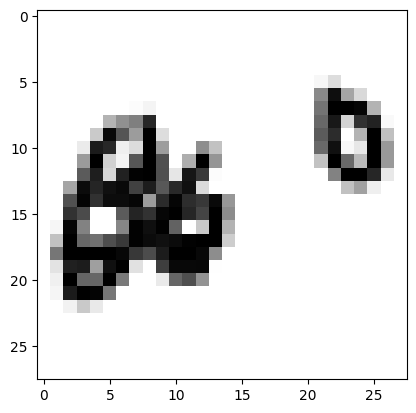

In [5]:
plt.imshow(x_train[501,:,:,0], cmap = 'binary')
plt.show()

In [6]:
input_dim = (28,28,1)
weight_init = RandomNormal(mean=0., stddev=0.02)

In [7]:
discriminator_input = keras.Input(shape=input_dim, name='discriminator_input')
x = Conv2D(64, 5, strides=2, padding="same",
      kernel_initializer=weight_init, name='discriminator_conv_0')(discriminator_input)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Conv2D(64, 5, strides=2, padding="same",
    kernel_initializer=weight_init, name='discriminator_conv_1')(x)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Conv2D(128, 5, strides=2, padding="same",
      kernel_initializer=weight_init, name='discriminator_conv_2')(x)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Conv2D(128, 5, strides=1, padding="same",
      kernel_initializer=weight_init, name='discriminator_conv_3')(x)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Flatten()(x)
discriminator_output = Dense(1, activation='sigmoid',
    kernel_initializer = RandomNormal(mean=0., stddev=0.02))(x)
discriminator = keras.Model(discriminator_input, discriminator_output, name = 'discriminator')
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (Input  [(None, 28, 28, 1)]       0         
 Layer)                                                          
                                                                 
 discriminator_conv_0 (Conv  (None, 14, 14, 64)        1664      
 2D)                                                             
                                                                 
 re_lu (ReLU)                (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 discriminator_conv_1 (Conv  (None, 7, 7, 64)          102464    
 2D)                                                             
                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [8]:

z_dim = 100

generator_input = keras.Input(shape=(z_dim,), name='generator_input')
x = Dense(np.prod((7, 7, 64)), kernel_initializer = RandomNormal(mean=0., stddev=0.02))(generator_input)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = Reshape((7,7,64))(x)
x = UpSampling2D()(x)
x = Conv2D(128, 5, padding="same", kernel_initializer=weight_init, name='generator_conv_0')(x)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = UpSampling2D()(x)
x = Conv2D(64, 5, padding="same", kernel_initializer=weight_init, name='generator_conv_1')(x)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = Conv2DTranspose(64, 5, strides=1, padding="same", kernel_initializer=weight_init, name='generator_conv_2')(x)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = Conv2DTranspose(1, 5, strides=1, padding="same", kernel_initializer=weight_init, name='generator_conv_3')(x)
generator_output = Activation('tanh')(x)
generator = keras.Model(generator_input, generator_output, name="generator")
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLaye  [(None, 100)]             0         
 r)                                                              
                                                                 
 dense_1 (Dense)             (None, 3136)              316736    
                                                                 
 batch_normalization (Batch  (None, 3136)              12544     
 Normalization)                                                  
                                                                 
 re_lu_4 (ReLU)              (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 64)        0 

In [9]:
### COMPILE DISCRIMINATOR

discriminator.compile(
  optimizer=RMSprop(lr=0.0008),
  loss = 'binary_crossentropy',
  metrics = ['accuracy']
)

In [10]:

### COMPILE THE FULL GAN

def set_trainable(m, val):
    m.trainable = val
    for l in m.layers:
        l.trainable = val

# 먼저discriminator를 훈련 불가능 상태로 만듬.
set_trainable(discriminator, False)

model_input = Input(shape=(z_dim,), name='model_input')
model_output = discriminator(generator(model_input))
model = Model(model_input, model_output)

model.compile(optimizer=RMSprop(learning_rate=0.0004) , loss='binary_crossentropy', metrics=['accuracy']
  , experimental_run_tf_function=False
)

# compile이 완료되었으므로, discriminator를 훈련 가능 상태로 복귀.
set_trainable(discriminator, True)

In [11]:

mode = 'build'
#mode = 'load'

if mode == 'build':
    model.save(SAVE_FOLDER)
else:
    model.load_weights(os.path.join(SAVE_FOLDER, 'weights/weights.h5'))

In [12]:
total_epoch = 0
d_losses = []
g_losses = []

In [13]:
def train_discriminator(x_train, batch_size):

    valid = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    idx = np.random.randint(0, x_train.shape[0], batch_size)
    true_imgs = x_train[idx]

    noise = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict(noise)

    d_loss_real, d_acc_real =   discriminator.train_on_batch(true_imgs, valid)
    d_loss_fake, d_acc_fake =   discriminator.train_on_batch(gen_imgs, fake)
    d_loss =  0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)

    return [d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake]

def train_generator(batch_size):
    valid = np.ones((batch_size,1))
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    return model.train_on_batch(noise, valid)



# 중간 epoch에서 생성 이미지를 샘플링하여 저장해두기 위한 함수
def sample_images(run_folder):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, z_dim))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * (gen_imgs + 1)
    gen_imgs = np.clip(gen_imgs, 0, 1)

    fig, axs = plt.subplots(r, c, figsize=(15,15))
    cnt = 0

    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % total_epoch))
    plt.close()

# discriminator와 generator를 번갈아가며, 학습
def train(x_train, batch_size, epochs, run_folder,
          print_every_n_batches = 50,
          ):

    global total_epoch
    for epoch in range(total_epoch, total_epoch + epochs):

        d = train_discriminator(x_train, batch_size)
        g = train_generator(batch_size)

        print ("%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (epoch, d[0], d[1], d[2], d[3], d[4], d[5], g[0], g[1]))

        d_losses.append(d)
        g_losses.append(g)

        if epoch % print_every_n_batches == 0:
            sample_images(run_folder)
            #model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
            model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
            model.save(run_folder)

        total_epoch += 1


In [14]:

BATCH_SIZE = 64
EPOCHS = 2000
PRINT_EVERY_N_BATCHES = 20

train(
    x_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    run_folder = SAVE_FOLDER,
    print_every_n_batches = PRINT_EVERY_N_BATCHES,
)

2/2 [==============================] - 8s 11ms/step
0 [D loss: (0.708)(R 0.691, F 0.724)] [D acc: (0.289)(0.578, 0.000)] [G loss: 0.669] [G acc: 1.000]
2/2 [==============================] - 0s 9ms/step
1 [D loss: (0.746)(R 0.616, F 0.876)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.638] [G acc: 1.000]
2/2 [==============================] - 0s 10ms/step
2 [D loss: (0.673)(R 0.609, F 0.737)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.487] [G acc: 1.000]
2/2 [==============================] - 0s 5ms/step
3 [D loss: (0.751)(R 0.450, F 1.052)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.522] [G acc: 1.000]
2/2 [==============================] - 0s 5ms/step
4 [D loss: (0.604)(R 0.459, F 0.749)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.355] [G acc: 1.000]
2/2 [==============================] - 0s 5ms/step
5 [D loss: (0.584)(R 0.194, F 0.974)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.557] [G acc: 1.000]
2/2 [==============================] - 0s 7ms/step
6 [D loss: (0.449)(R 0.181, F 0.717)] [D 

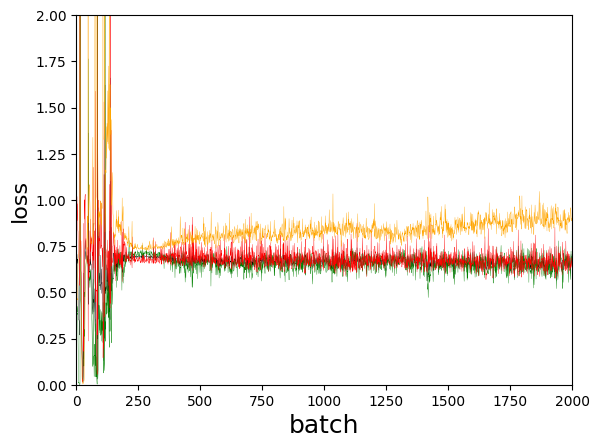

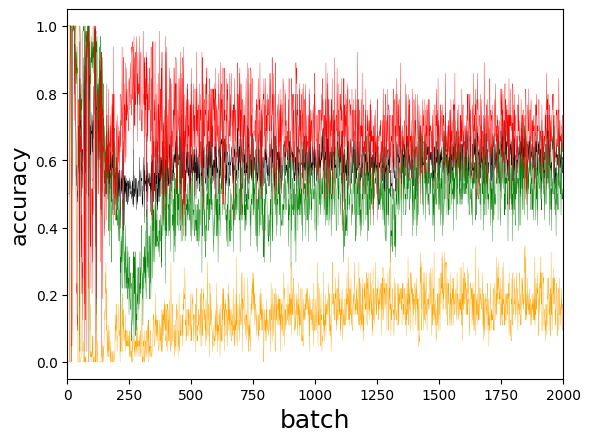

In [ ]:
fig = plt.figure()
plt.plot([x[0] for x in d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in d_losses], color='red', linewidth=0.25)
plt.plot([x[0] for x in g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
plt.ylim(0, 2)

plt.show()

fig = plt.figure()
plt.plot([x[3] for x in d_losses], color='black', linewidth=0.25)
plt.plot([x[4] for x in d_losses], color='green', linewidth=0.25)
plt.plot([x[5] for x in d_losses], color='red', linewidth=0.25)
plt.plot([x[1] for x in g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('accuracy', fontsize=16)

plt.xlim(0, 2000)

plt.show()

1/1 [==============================] - 0s 412ms/step


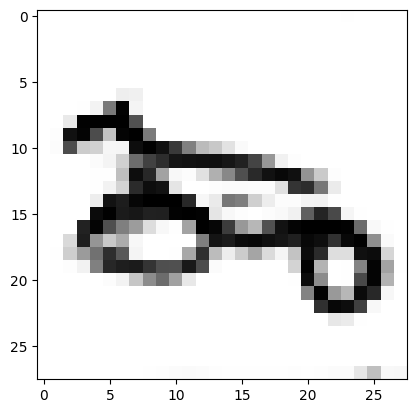

In [ ]:

import numpy as np
#z_dim = 100

noise = np.random.normal(0, 1, (1, z_dim))
img = generator.predict(noise)
plt.imshow(img[0].squeeze(), cmap='binary')
plt.show()


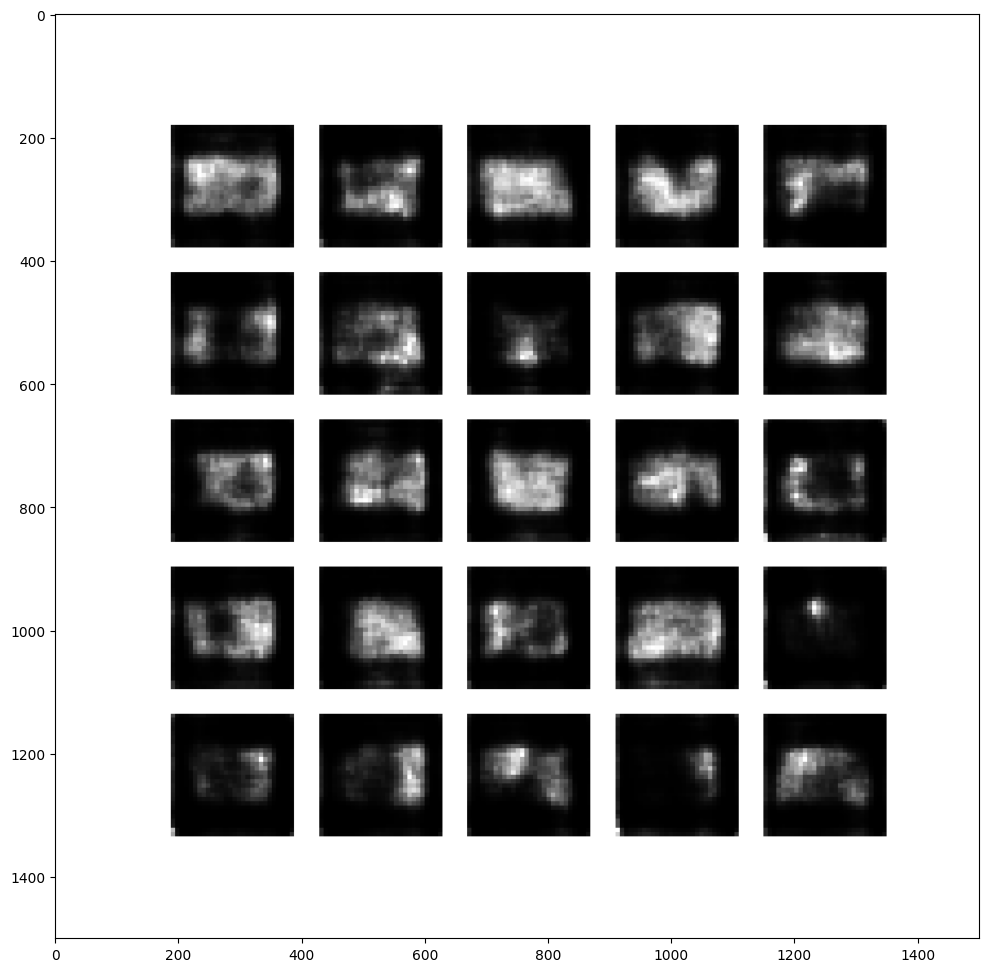

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mp_image

image = mp_image.imread('gan_data/images/sample_%d.png' % 20)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

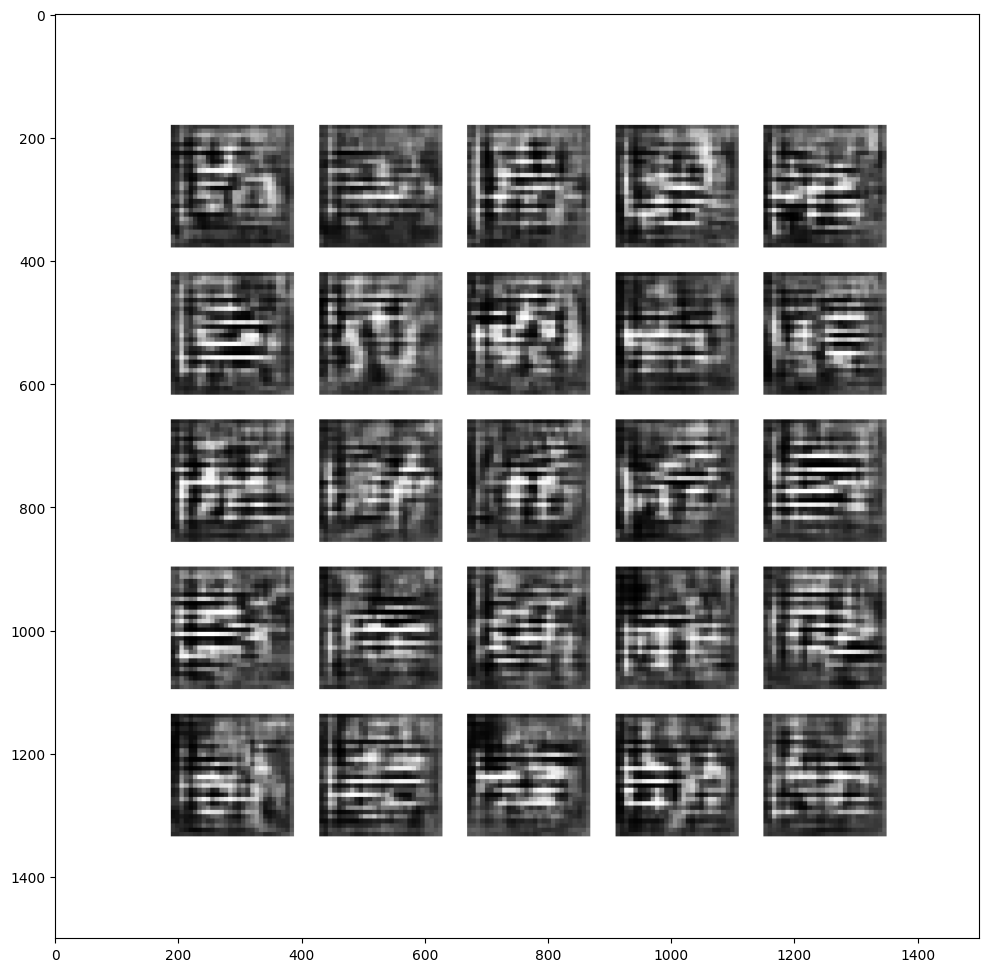

In [ ]:

image = mp_image.imread('gan_data/images/sample_%d.png' % 100)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

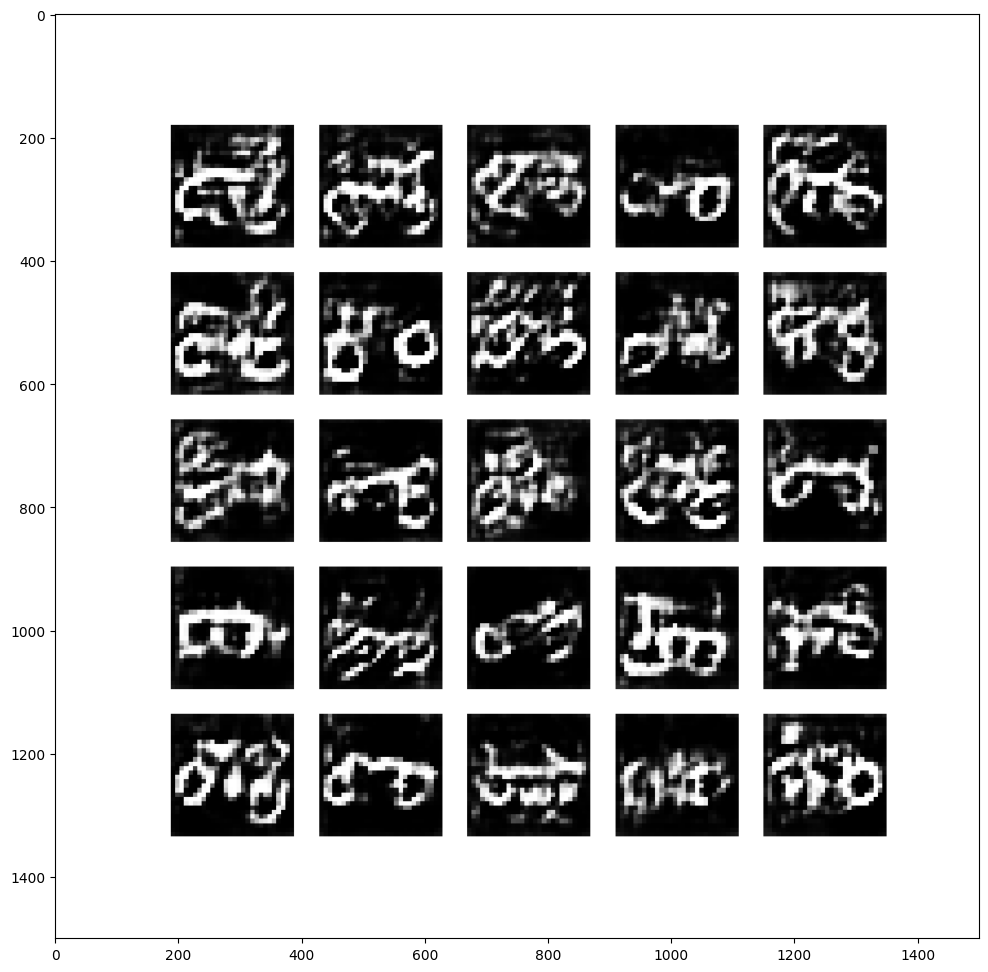

In [ ]:

image = mp_image.imread('gan_data/images/sample_%d.png' % 200)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

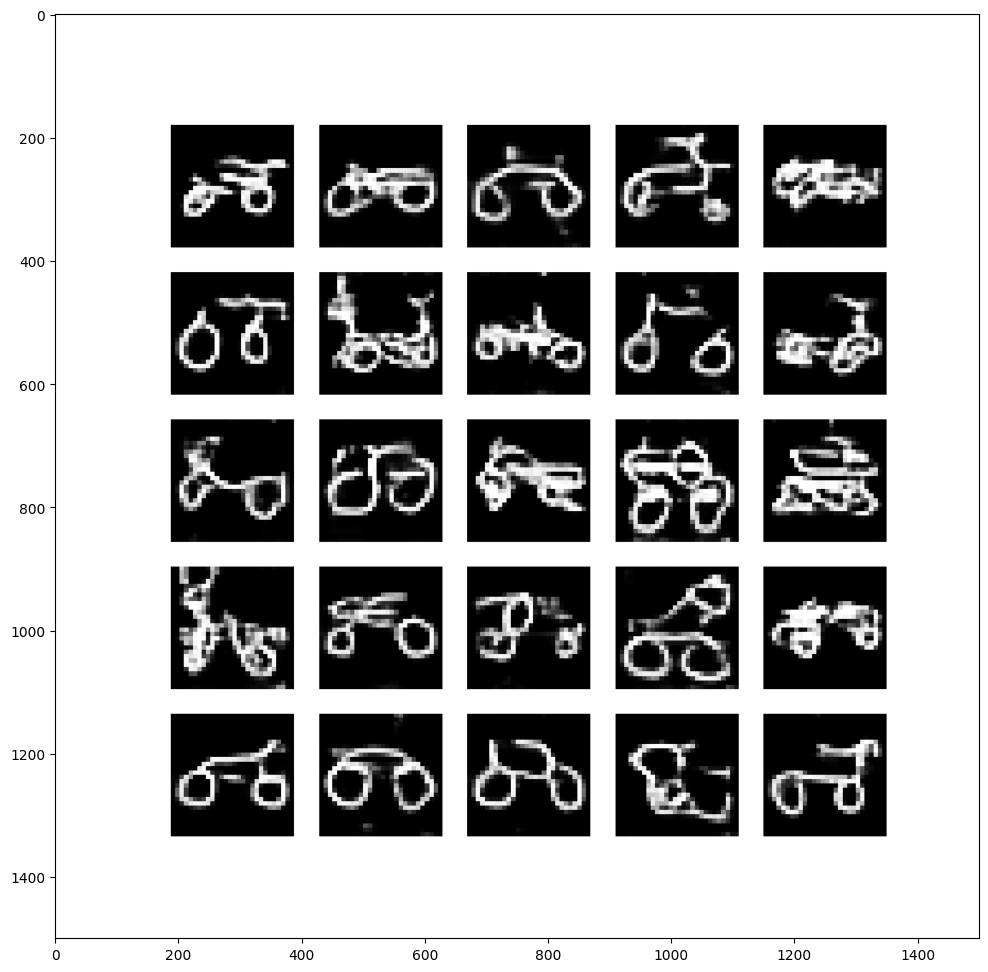

In [ ]:


image = mp_image.imread('gan_data/images/sample_%d.png' % 1980)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()